In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

from argparse import ArgumentParser

In [2]:

%load_ext autoreload
%autoreload 2

## IO

In [3]:
from sgs_tools.io.um import read_stash_files, rename_variables, restrict_ds, unify_coords
from sgs_tools.geometry.staggered_grid import interpolate_to_grid

In [4]:
def data_ingest(dir_path: Path,
                fname_pattern: str,
                res: float,
                file_codes: list[str] =  ['b', 'r'],
                required_fields: list[str] = ['u', 'v', 'w', 'theta'],
                ):
    ''' read and pre-process UM data
    :param dir_path: directory containing UM NetCDF files
    :param fname_pattern: glob pattern of filenames to read excluding single-letter file codes
    :param float: horizontal resolution (will use to overwrite horizontal coordinates). **NB** works for ideal simulations
    :param file_codes: single-letter filename codes distinguishing diagnostic output files, default is ['b', 'r']
    :parm  required_fields: list of fields to read and pre-process. Defaults to ['u', 'v', 'w', 'theta']
    '''
    # all the fields we will need for the Cs calculations
    simulation = read_stash_files(dir_path, fname_pattern,
                               file_codes=file_codes)
    #parse UM stash codes into variable names
    simulation = rename_variables(simulation)

    #restrict to interesting fields and rename to simple names
    simulation = restrict_ds(simulation, fields = required_fields)

    #unify coordinatesh
    simulation = unify_coords(simulation , res= res)

    #interpolate all vars to a cell-centred grid
    centre_dims =['x_centre', 'y_centre', 'z_theta']
    simulation = interpolate_to_grid(simulation, centre_dims, drop_coords=True)
    #rename spatial dsimensions to 'xyz'
    simple_dims = ['x','y','z']
    dim_names = {d_new : d_old for d_new, d_old in zip (centre_dims, simple_dims)}
    simulation = simulation.rename(dim_names)
    
    return simulation
    

In [5]:
%%time
ext_path = Path('/Volumes/Work/NERC_postdoc/online_datatest')
# ext_path = Path('/Users/dv270/NERC_postdoc/online_datatest/')
rel_path = 'CBL/gefsta_reference/Dynamic_smag_2scales_trilinear_no_pr'
rose = 'da134'
resolution = 500.0
file_codes = ['r', 'b']

#read UM stasth files: data
simulation =data_ingest(ext_path / rel_path, f"{rose}_{resolution:.0f}", resolution,
                               file_codes=file_codes,
                        required_fields = ['u', 'v', 'w', 'theta'],
                        )

Reading /Volumes/Work/NERC_postdoc/online_datatest/CBL/gefsta_reference/Dynamic_smag_2scales_trilinear_no_pr/da134_500*[rb]*.nc
CPU times: user 987 ms, sys: 356 ms, total: 1.34 s
Wall time: 10.7 s


In [6]:
from sgs_tools.geometry.staggered_grid import compose_vector_components_on_grid
from sgs_tools.physics.fields import strain_from_vel
from sgs_tools.geometry.vector_calculus import grad_scalar

In [7]:
%%time
simple_dims = ["x", "y", "z"]  # coordinates already exist in simulation
vel = compose_vector_components_on_grid(
    [simulation["u"], simulation["v"], simulation["w"]],
    simple_dims,
    name="vel",
    vector_dim="c1",
)

# compute strain and potential temperature gradient
sij = strain_from_vel(
    vel,
    space_dims=simple_dims,
    vec_dim="c1",
    new_dim="c2",
    make_traceless=True,
)
grad_theta = grad_scalar(
    simulation["theta"],
    space_dims=simple_dims,
    new_dim_name="c1",
    name="grad_theta",
)

CPU times: user 31.9 ms, sys: 2.07 ms, total: 34 ms
Wall time: 33.9 ms


In [8]:
from sgs_tools.sgs.Smagorinsky import (
    DynamicSmagorinskyHeatModel,
    DynamicSmagorinskyVelocityModel,
    SmagorinskyHeatModel,
    SmagorinskyVelocityModel,
)

In [9]:
%%time
# setup dynamic Smagorinsky model for velocity
smag_vel = SmagorinskyVelocityModel(
    vel, sij, cs=1.0, dx=resolution, tensor_dims=["c1", "c2"]
)
dyn_smag_vel = DynamicSmagorinskyVelocityModel(smag_vel)

# setup dynamic Smagorinsky model for potential temperature
smag_theta = SmagorinskyHeatModel(
    vel,
    grad_theta,
    sij,
    ctheta=1.0,
    dx=resolution,
    tensor_dims=["c1", "c2"],
)
dyn_smag_theta = DynamicSmagorinskyHeatModel(smag_theta, simulation["theta"])


CPU times: user 51 µs, sys: 1 µs, total: 52 µs
Wall time: 54.1 µs


In [10]:
from sgs_tools.sgs.dynamic_coefficient import dynamic_coeff
from sgs_tools.sgs.filter import Filter, box_kernel, weight_gauss_3d, weight_gauss_5d
from typing import Sequence

In [11]:
def make_filter(shape: str, scale: int, dims=Sequence[str]) -> Filter:
    """make filter object. **NB** Choices are limited!!!

    :param shape: shape of filter kernel
    :param scale: length scale of filter kernel
    :param dims: dimensions along which to filter
    """
    if shape == "gaussian":
        if scale == 2:
            return Filter(weight_gauss_3d, dims)
        elif scale == 4:
            return Filter(weight_gauss_5d, dims)
        else:
            raise ValueError(f"Unsupported filter scale{scale} for gaussian filters")
    elif shape == "box":
        return Filter(box_kernel([scale, scale]), dims)
    else:
        raise ValueError(f"Unsupported filter shape {shape}")


In [70]:
%%time 
scale = 2 
regularization_scale = 2
filter = make_filter('box', scale, ["x", "y"])
regularization = make_filter('box', regularization_scale, ["x", "y"])

# compute isotropic Cs for velocity
cs_isotropic = dynamic_coeff(
    dyn_smag_vel, filter, regularization, ["c1", "c2"]
)
# # add scale coordinate to be able to concatenate
# cs_isotropic = cs_isotropic.expand_dims(scale=[scale])
# cs_isotropic = cs_isotropic.assign_coords(
#     regularization_scale=("scale", [regularization_scale])
# )

CPU times: user 53.4 ms, sys: 1.37 ms, total: 54.8 ms
Wall time: 57.9 ms


In [69]:
%%time
# compute diagonal Cs for velocity
cs_diagonal = dynamic_coeff(
    dyn_smag_vel, filter, regularization, ["c2"]
)
# # add scale coordinate to be able to concatenate
# cs_diagonal = cs_diagonal.expand_dims(scale=[scale])
# cs_diagonal = cs_diagonal.assign_coords(
#     regularization_scale=("scale", [regularization_scale])
# )

CPU times: user 42.1 ms, sys: 13.4 ms, total: 55.6 ms
Wall time: 112 ms


In [78]:
cs_iso_at_scale = xr.concat([cs_isotropic,], dim="scale")  
cs_diag_at_scale = xr.concat([cs_diagonal,], dim="scale")

coeff_at_scale = xr.Dataset(
    {
        "Cs_isotropic": cs_iso_at_scale,
        "Cs_diagonal": cs_diag_at_scale,
    }
)

In [81]:

def add_scale_coords(
    ds, scales: Sequence[float], regularization_scales: Sequence[float]
):
    """add scale dim and regularization_scale coordinate
    :param ds: input dataset/dataarray
    :param scales: the coordinates for the scale dimension
    :param regularization_scales: sequence of coordinates
    :return: the update dataset/dataarray
    """
    if "scale" not in ds.dims:
        print('expanding')
        ds = ds.expand_dims(scale=scales)
    else:
        print("assigning")
        ds = ds.assign_coords(scale=("scale", scales))
    ds = ds.assign_coords(regularization_scale=("scale", regularization_scales))
    ds["scale"].attrs["units"] = r"$\Delta x$"
    ds["regularization_scale"].attrs["units"] = r"$\Delta x$"
    return ds

In [80]:
coeff_at_scale

<xarray.Dataset>
Dimensions:                    (x: 128, y: 128, z: 65, t_0: 25, scale: 1, c1: 3)
Coordinates: (12/18)
    x_cu                       (x) float64 0.25 0.75 1.25 ... 62.75 63.25 nan
    y_cu                       (y) float64 0.25 0.75 1.25 ... 62.75 63.25 63.75
    rholev_eta_rho             (z) float64 0.001778 0.003333 ... 0.9678 nan
    rholev_C_rho               (z) float64 dask.array<chunksize=(65,), meta=np.ndarray>
    rholev_model_level_number  (z) float64 dask.array<chunksize=(65,), meta=np.ndarray>
    min15T0_0                  (t_0) object 1999-02-23 07:30:00 ... 1999-02-2...
    ...                         ...
    y_theta                    (y) float64 0.25 0.75 1.25 ... 62.75 63.25 63.75
    thlev_eta_theta            (z) float64 0.001778 0.003333 ... 0.9678 1.0
  * z                          (z) float64 5.334 9.999 16.0 ... 2.903e+03 3e+03
    thlev_C_theta              (z) float64 dask.array<chunksize=(65,), meta=np.ndarray>
    thlev_model_level_number   (z) int32 dask.array<chunksize=(65,), meta=np.ndarray>
  * c1                         (c1) int64 1 2 3
Dimensions without coordinates: scale
Data variables:
    Cs_isotropic               (scale, t_0, z, y, x) float64 dask.array<chunksize=(1, 25, 65, 128, 128), meta=np.ndarray>
    Cs_diagonal                (scale, c1, t_0, z, y, x) float64 dask.array<chunksize=(1, 1, 25, 65, 128, 128), meta=np.ndarray>

In [82]:
add_scale_coords(coeff_at_scale, [2], [2])

assigning


<xarray.Dataset>
Dimensions:                    (x: 128, y: 128, z: 65, t_0: 25, scale: 1, c1: 3)
Coordinates: (12/20)
    x_cu                       (x) float64 0.25 0.75 1.25 ... 62.75 63.25 nan
    y_cu                       (y) float64 0.25 0.75 1.25 ... 62.75 63.25 63.75
    rholev_eta_rho             (z) float64 0.001778 0.003333 ... 0.9678 nan
    rholev_C_rho               (z) float64 dask.array<chunksize=(65,), meta=np.ndarray>
    rholev_model_level_number  (z) float64 dask.array<chunksize=(65,), meta=np.ndarray>
    min15T0_0                  (t_0) object 1999-02-23 07:30:00 ... 1999-02-2...
    ...                         ...
  * z                          (z) float64 5.334 9.999 16.0 ... 2.903e+03 3e+03
    thlev_C_theta              (z) float64 dask.array<chunksize=(65,), meta=np.ndarray>
    thlev_model_level_number   (z) int32 dask.array<chunksize=(65,), meta=np.ndarray>
  * c1                         (c1) int64 1 2 3
  * scale                      (scale) int64 2
    regularization_scale       (scale) int64 2
Data variables:
    Cs_isotropic               (scale, t_0, z, y, x) float64 dask.array<chunksize=(1, 25, 65, 128, 128), meta=np.ndarray>
    Cs_diagonal                (scale, c1, t_0, z, y, x) float64 dask.array<chunksize=(1, 1, 25, 65, 128, 128), meta=np.ndarray>

In [17]:
%%time
coeff_at_scale.load()

/Users/dv270/prog/miniconda3/envs/py311_update/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 35.1 s, sys: 1min 28s, total: 2min 3s
Wall time: 56.8 s


<xarray.Dataset>
Dimensions:                    (scale: 1, x: 128, y: 128, z: 65, t_0: 25, c1: 3)
Coordinates: (12/20)
  * scale                      (scale) int64 2
    x_cu                       (x) float64 0.25 0.75 1.25 ... 62.75 63.25 nan
    y_cu                       (y) float64 0.25 0.75 1.25 ... 62.75 63.25 63.75
    rholev_eta_rho             (z) float64 0.001778 0.003333 ... 0.9678 nan
    rholev_C_rho               (z) float64 0.9982 0.9967 0.9947 ... 0.03222 nan
    rholev_model_level_number  (z) float64 1.417 2.437 3.45 ... 63.5 64.5 nan
    ...                         ...
    thlev_eta_theta            (z) float64 0.001778 0.003333 ... 0.9678 1.0
  * z                          (z) float64 5.334 9.999 16.0 ... 2.903e+03 3e+03
    thlev_C_theta              (z) float64 0.9982 0.9967 0.9947 ... 0.03222 0.0
    thlev_model_level_number   (z) int32 1 2 3 4 5 6 7 ... 59 60 61 62 63 64 65
    regularization_scale       (scale) int64 2
  * c1                         (c1) int64 1 2 3
Data variables:
    Cs_isotropic               (scale, t_0, z, y, x) float64 nan nan ... nan nan
    Cs_diagonal                (scale, c1, t_0, z, y, x) float64 nan nan ... nan

Text(0.05, 0.85, 'Cs_isotropic')

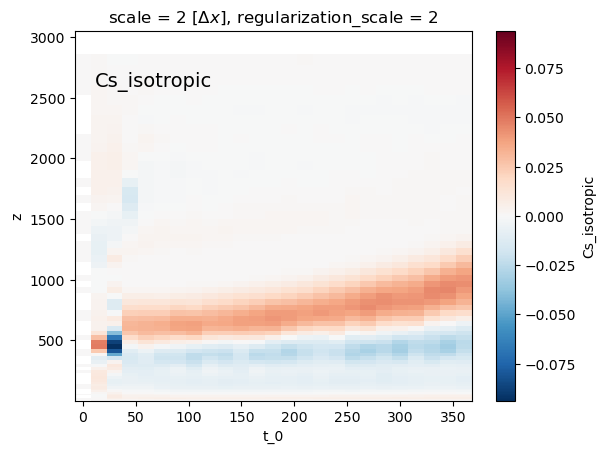

In [67]:
o = coeff_at_scale['Cs_isotropic'].mean(['x','y']).plot(x='t_0', row=None, col_wrap=3)
o.axes.text(0.05, 0.85, "Cs_isotropic", fontsize=14, transform=o.axes.transAxes)

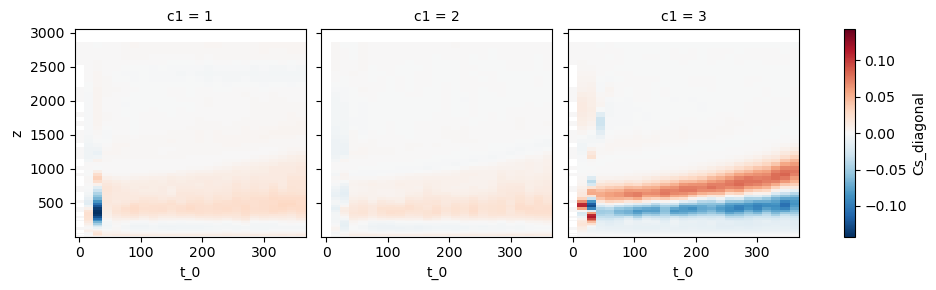

In [57]:
o = coeff_at_scale['Cs_diagonal'].mean(['x','y']).plot(x='t_0', col='c1', row=None, col_wrap=3)

In [59]:
for ax in o.fig.axes:
    ax.text(0.05, 0.85, "Ctheta_diagonal", fontsize=14, transform=ax.transAxes)
            

In [64]:
5 in range(1,4)

False

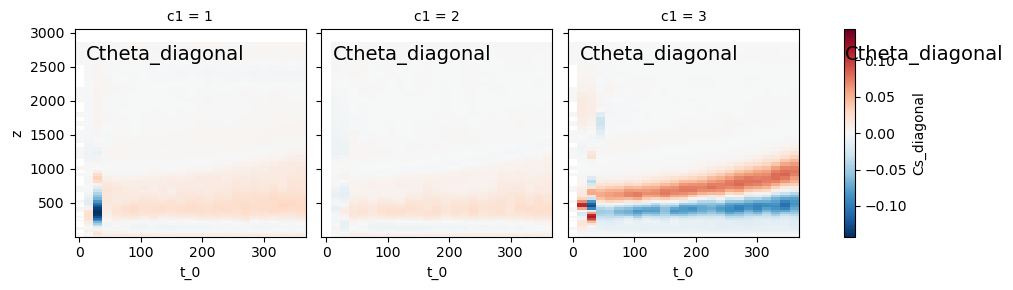

In [60]:
o.fig

In [56]:
o.fig.axes

[<Axes: title={'center': 'c1 = 1'}, xlabel='t_0', ylabel='z'>,
 <Axes: title={'center': 'c1 = 2'}, xlabel='t_0'>,
 <Axes: title={'center': 'c1 = 3'}, xlabel='t_0'>,
 <Axes: label='<colorbar>', ylabel='Cs_diagonal'>]

In [20]:
type(o)

xarray.plot.facetgrid.FacetGrid

In [25]:
o.fig.show()

/var/folders/jc/flfv27rx1170xtcs05l2kmzr0000gp/T/ipykernel_25781/1011179078.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  o.fig.show()


In [42]:
f = o.get_figure()

In [43]:
f.show()

/var/folders/jc/flfv27rx1170xtcs05l2kmzr0000gp/T/ipykernel_24035/1831071131.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


In [ ]:
from dask.diagnostics import ProgressBar